# BikeShareTO 2020
Script to animate every single BikeShareTO trip in 2020. Made by Hanno Rein (hanno@hanno-rein.de).

In [61]:
import matplotlib.animation as manimation
import numpy as np
import matplotlib.pyplot as plt
import mplleaflet
import glob
import csv
import json
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import time
import datetime
import shapely.geometry as sgeom
datadir = "/Users/rein/Downloads/bikeshare-ridership-2020/"

In [3]:
imagery = OSM() # Open Street Map Background
target = sgeom.box(-8845789.447124064,  5407072.625232799, -8825113.537693309, 5418410.579948176) # Downtown Toronto Coordinates:
z_target = 13 # zoom
tiles = list(imagery.find_images(target, target_z=z_target))
composite = imagery.image_for_domain(target, target_z=z_target)

In [4]:
stations = {} # Station ID -> Lat/Lon
with open(datadir+"station_information.json") as f:
    j = json.load(f)
    for k in j["data"]["stations"]:
        stations[int(k["station_id"])] = [k["lat"],k["lon"]]

In [54]:
geoall = np.zeros((2911318,7))
j = 0
for f in glob.glob(datadir+"2020-*.csv"):
    dt = np.genfromtxt(f, delimiter=',',skip_header=1,usecols=(4),dtype=str)
    d = np.genfromtxt(f, delimiter=',',skip_header=1,usecols=(1,3,6,2))
    print(f)
    for i, r in enumerate(d):
        ts = datetime.datetime.strptime(dt[i], "%m/%d/%Y %H:%M").timestamp()
        dur = int(r[3])
        try:         
            id1 = int(r[1])
            id2 = int(r[2])
            v = [r[0],stations[id1][0],stations[id1][1],stations[id2][0],stations[id2][1],ts,dur]
        except:
            continue
        geoall[j] = v 
        j += 1
geoall = geoall[:j]    

/Users/rein/Downloads/bikeshare-ridership-2020/2020-02.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-03.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-01.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-10.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-04.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-05.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-11.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-07.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-12.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-06.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-08.csv
/Users/rein/Downloads/bikeshare-ridership-2020/2020-09.csv


In [183]:
# Estimate video size
ts0 = datetime.datetime.strptime("01/01/2020 00:01", "%m/%d/%Y %H:%M").timestamp()
dt0 = 60 # initial timestep
dtincr = 1 # speedup
Nframes = 0
dt = dt0
ts = ts0
while int(datetime.datetime.utcfromtimestamp(ts).strftime("%Y"))<2021:
    ts += dt
    dt += dtincr
    Nframes +=1
print("Number of frames:", Nframes, "Runtime (minutes):", Nframes/30/60)

Nframes 7892 min: 4.384444444444444


0.00%
6.34%
12.67%
19.01%
25.34%
31.68%
38.01%
44.35%
50.68%
57.02%
63.36%
69.69%
76.03%
82.36%
88.70%
95.03%


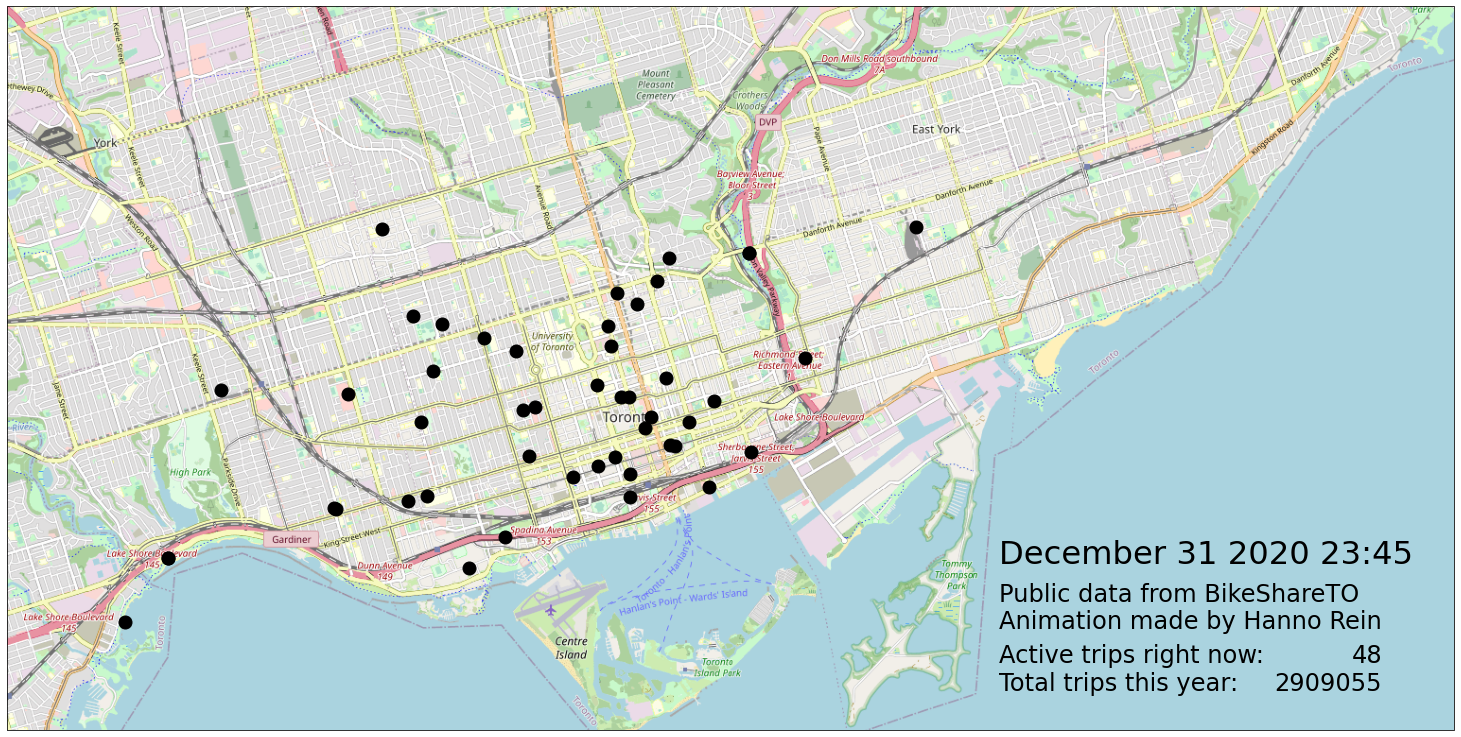

In [184]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='BikeShareTO 2020', artist='Hanno Rein', extra_args=['-vcodec', 'libx264'])
writer = FFMpegWriter(fps=30, metadata=metadata)
scale = 1022/508 # random way to tune the final size
fig,ax = plt.subplots(1,1, subplot_kw={'projection': imagery.crs},figsize=(scale*10,scale*10/734*374))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

dt = dt0
ts = ts0

with writer.saving(fig, "bikeshareto2020.mp4", 100):
    for i in range(Nframes):
        if i%500==0: # progress
            print("%.2f%%"%(i/Nframes*100))
        ax.clear()
        ax.set_xlim([composite[1][0],composite[1][1]])
        ax.set_ylim([composite[1][2],composite[1][3]])
        g1 = geoall[geoall[:,5]<ts]
        triptotal = len(g1)
        g2 = g1[g1[:,5]+g1[:,6]>ts]
        for k in g2: # all trips currently active
            dur = k[6]
            t0 = k[5]
            rat = (ts-t0)/dur
            xint = (1.-rat)*k[2] + rat*k[4]
            yint = (1.-rat)*k[1] + rat*k[3]
            ax.plot(xint,yint,ms=13,marker='o',linestyle='',color="black",transform=ccrs.PlateCarree());
        tripnow = len(g2)
        timest = datetime.datetime.utcfromtimestamp(ts).strftime("%B %-d %Y %H:%M")
        ax.text(0.685,0.23,timest, transform=ax.transAxes, fontsize=16*scale)
        ax.text(0.685,0.14,"Public data from BikeShareTO\nAnimation made by Hanno Rein", transform=ax.transAxes, fontsize=12*scale)
        ax.text(0.685,0.055,"Active trips right now: \nTotal trips this year: ", transform=ax.transAxes, fontsize=12*scale)
        ax.text(0.95,0.055,"%d\n%d"%(tripnow, triptotal), transform=ax.transAxes, fontsize=12*scale,horizontalalignment="right")

        ax.imshow(composite[0], extent=composite[1], origin=composite[2])
        writer.grab_frame()
        ts += dt
        dt += dtincr
writer.finish()           